# Bibliotek

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skyfield.api import EarthSatellite, load
from datetime import datetime, timedelta

# Funksjoner og Konstanter

In [ ]:
earth_radius_km = 6371 

def create_satellite(tle_line1, tle_line2):
    return EarthSatellite(tle_line1, tle_line2)

def propagate_orbit(satellite, start_time, end_time, time_step):
    ts = load.timescale()
    times = ts.utc(start_time.year, start_time.month, start_time.day, 
                   start_time.hour, start_time.minute, start_time.second + np.arange(0, int((end_time - start_time).total_seconds()), time_step))
    geocentric = satellite.at(times)
    positions = geocentric.position.km
    return positions

def plot_orbits(positions_list):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the Earth
    u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:50j]
    x = earth_radius_km * np.cos(u) * np.sin(v)
    y = earth_radius_km * np.sin(u) * np.sin(v)
    z = earth_radius_km * np.cos(v)
    ax.plot_surface(x, y, z, color='c', alpha=0.6, rstride=4, cstride=4, label='Earth')
    
    # Plot each satellite's orbit
    for i, positions in enumerate(positions_list):
        ax.plot(positions[0], positions[1], positions[2], label=f'Orbit {i+1}')
    
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')
    ax.set_title('3D Orbit Simulation')
    plt.legend()
    plt.show()

# Analyse

C:\Users\skaug\AppData\Local\Temp\ipykernel_7476\1899083902.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start_time = datetime.utcnow()


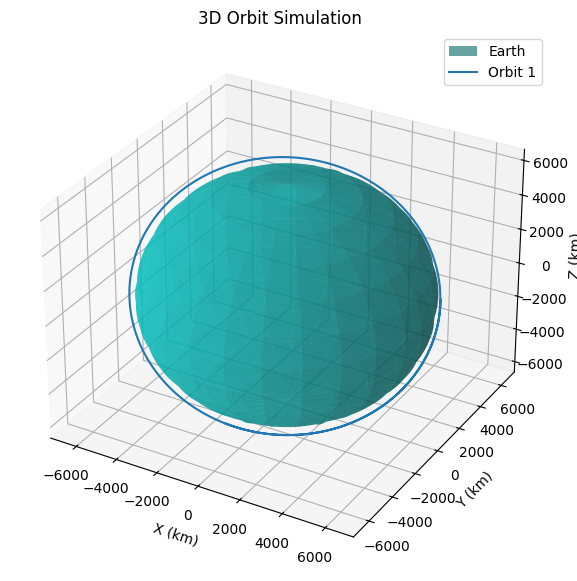

In [92]:
tle_lines = [
    ('1 25544U 98067A   20334.54791667  .00016717  00000-0  10270-3 0  9000', 
     '2 25544  51.6442  21.4614 0001448  45.3583  314.7000 15.49112345  9000'),
    # Add more TLE lines here if needed
]

start_time = datetime.utcnow()
end_time = start_time + timedelta(hours=2)
time_step = 1  # seconds

positions_list = []
for tle_line1, tle_line2 in tle_lines:
    satellite = create_satellite(tle_line1, tle_line2)
    positions = propagate_orbit(satellite, start_time, end_time, time_step)
    positions_list.append(positions)

plot_orbits(positions_list)